In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import math

import pyreadr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
# from keras.utils import plot_model
# import pydot
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.2-arm64-arm-64bit
Tensor Flow Version: 2.18.0
Keras Version: 3.9.0

Python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
Pandas 2.2.2
Scikit-Learn 1.4.2
GPU is NOT AVAILABLE


In [ ]:
import os
notebook_dir = "/Users/monamousavi/Dropbox/Causal_climate/My_own_Shared/Takashi_code/Rlearner/Codes"  
os.chdir(notebook_dir)  # Change directory
print(os.getcwd())  


/Users/monamousavi/Dropbox/Causal_climate/My_own_Shared/Takashi_code/Rlearner/Codes


In [12]:
data_2nd_stage = pyreadr.read_r(r'./data_20230504/data_2nd_stage.rds')[None] 
evall_N_seq = pyreadr.read_r(r'./data_20230504/evall_N_seq.rds')[None] 

df_train_sim_id = pd.read_csv('./Output_ann_Train_5field/df_train_sim_id.csv')

In [5]:
sim_id_train = np.array(df_train_sim_id.iloc[1])
sim_id_train = np.delete(sim_id_train,0,0)

sim_id_train[0]

124

# Run line by line 

In [25]:
sim_ids = np.unique(data_2nd_stage.sim)

sim_ids_ = np.delete(sim_ids, j, 0)

    # sim_id_train = np.random.choice(sim_ids_, size=10, replace=True, p=None)
sim_id_train = np.array(df_train_sim_id.iloc[1])
sim_id_train = np.delete(sim_id_train,0,0)
    
    # df_train_sim_id = pd.concat([df_train_sim_id, pd.DataFrame(sim_id_train).T])

sim_id_test = sim_ids[j]

dataset = data_2nd_stage[(data_2nd_stage['sim']==sim_id_train[0]) |
                            (data_2nd_stage['sim']==sim_id_train[1]) |          
                            (data_2nd_stage['sim']==sim_id_train[2]) |
                            (data_2nd_stage['sim']==sim_id_train[3]) |
                            (data_2nd_stage['sim']==sim_id_train[4])].reset_index(drop=True)

dataset = dataset[['y_tilde','Nk','plateau','b0','T_1_tilde','T_2_tilde','T_3_tilde']]

train_dataset = dataset.sample(frac=0.8, random_state=0)
val_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
val_features = val_dataset.copy()

train_labels = train_features.pop('y_tilde')
val_labels = val_features.pop('y_tilde')

scaler = StandardScaler()
scaler.fit(train_features)
scaled_train_features = scaler.transform(train_features)
scaled_val_features = scaler.transform(val_features)

In [56]:
# define architecture: necesssary to recompile the weights
input = keras.Input(shape=(6,)) # 
x = layers.Lambda(lambda x: x[:, :3], output_shape=(3,))(input)
T = layers.Lambda(lambda x: x[:, 3:], output_shape=(3,))(input)
#T1 = layers.Lambda(lambda x: x[:, 0], output_shape=(1,))(T)
#T2 = layers.Lambda(lambda x: x[:, 1], output_shape=(1,))(T)
#T3 = layers.Lambda(lambda x: x[:, 2], output_shape=(1,))(T)
T1 = layers.Lambda(lambda x: x[:, 0:1], output_shape=(1,))(T)
T2 = layers.Lambda(lambda x: x[:, 1:2], output_shape=(1,))(T)
T3 = layers.Lambda(lambda x: x[:, 2:3], output_shape=(1,))(T)
dense1 = layers.Dense(64, activation='relu')(x)
dense1 = layers.Dense(64, activation='relu')(dense1)
dense1 = layers.Dense(1, activation='linear')(dense1)
dense1 = layers.Multiply()([dense1, T1])
dense2 = layers.Dense(64, activation='relu')(x)
dense2 = layers.Dense(64, activation='relu')(dense2)
dense2 = layers.Dense(1, activation='linear')(dense2)
dense2 = layers.Multiply()([dense2, T2])
dense3 = layers.Dense(64, activation='relu')(x)
dense3 = layers.Dense(64, activation='relu')(dense3)
dense3 = layers.Dense(1, activation='linear')(dense3)
dense3 = layers.Multiply()([dense3, T3])
output = layers.Add()([dense1, dense2, dense3])
model = keras.models.Model(input,output)
# model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),loss='mean_absolute_error')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_absolute_error')

early_stopping =  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=10)

history = model.fit(
        scaled_train_features,
        train_labels,
        validation_data = (scaled_val_features,val_labels),
        # validation_split=0.2,
        verbose=0, epochs=500, batch_size=512, callbacks=[early_stopping])

In [42]:
history

In [63]:
val_predictions = model.predict(scaled_val_features).flatten() # Needs to be append to a certain array?
#val_predictions = model.predict(scaled_val_features)
outcome_val = pd.DataFrame([val_predictions,val_labels]).T
outcome_val.rename(columns={0: "pred", 1: "true"}, inplace=True)
outcome_val.to_csv('./Res_1/validation_{0}.csv'.format(sim_id_test))


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


R² Score: 0.4233


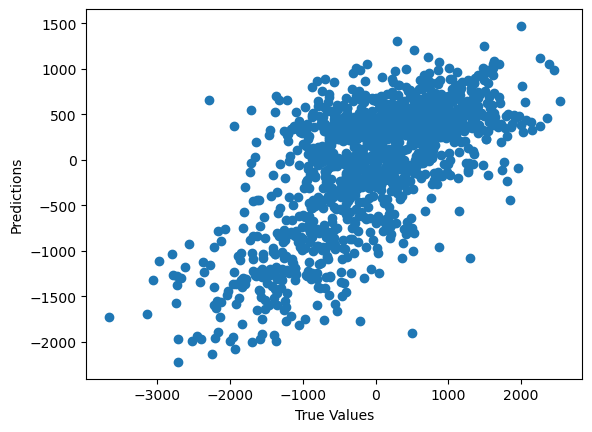

In [66]:
plt.scatter(val_labels, val_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

from sklearn.metrics import r2_score

r2 = r2_score(val_labels, val_predictions)
print(f"R² Score: {r2:.4f}")

In [61]:

print(val_labels.shape)
print(val_predictions.shape)

(1440,)
(1440,)


In [54]:
print(val_predictions.(head))

SyntaxError: invalid syntax (591499524.py, line 1)

# Multiple input DNN

In [67]:
num = len(np.unique(data_2nd_stage.sim))
# df_train_sim_id = pd.DataFrame()

for j in tqdm(range(2)):
# for j in tqdm(range(5)):
    sim_ids = np.unique(data_2nd_stage.sim)

    sim_ids_ = np.delete(sim_ids, j, 0)

    # sim_id_train = np.random.choice(sim_ids_, size=10, replace=True, p=None)
    sim_id_train = np.array(df_train_sim_id.iloc[1])
    sim_id_train = np.delete(sim_id_train,0,0)
    
    # df_train_sim_id = pd.concat([df_train_sim_id, pd.DataFrame(sim_id_train).T])

    sim_id_test = sim_ids[j]

    dataset = data_2nd_stage[(data_2nd_stage['sim']==sim_id_train[0]) |
                            (data_2nd_stage['sim']==sim_id_train[1]) |          
                            (data_2nd_stage['sim']==sim_id_train[2]) |
                            (data_2nd_stage['sim']==sim_id_train[3]) |
                            (data_2nd_stage['sim']==sim_id_train[4])].reset_index(drop=True)

    dataset = dataset[['y_tilde','Nk','plateau','b0','T_1_tilde','T_2_tilde','T_3_tilde']]

    train_dataset = dataset.sample(frac=0.8, random_state=0)
    val_dataset = dataset.drop(train_dataset.index)

    train_features = train_dataset.copy()
    val_features = val_dataset.copy()

    train_labels = train_features.pop('y_tilde')
    val_labels = val_features.pop('y_tilde')

    scaler = StandardScaler()
    scaler.fit(train_features)
    scaled_train_features = scaler.transform(train_features)
    scaled_val_features = scaler.transform(val_features)

    # define architecture: necesssary to recompile the weights
    input = keras.Input(shape=(6,)) # 
    x = layers.Lambda(lambda x: x[:, :3], output_shape=(3,))(input)
    T = layers.Lambda(lambda x: x[:, 3:], output_shape=(3,))(input)
    T1 = layers.Lambda(lambda x: x[:, 0:1], output_shape=(1,))(T)
    T2 = layers.Lambda(lambda x: x[:, 1:2], output_shape=(1,))(T)
    T3 = layers.Lambda(lambda x: x[:, 2:3], output_shape=(1,))(T)
    dense1 = layers.Dense(64, activation='relu')(x)
    dense1 = layers.Dense(64, activation='relu')(dense1)
    dense1 = layers.Dense(1, activation='linear')(dense1)
    dense1 = layers.Multiply()([dense1, T1])
    dense2 = layers.Dense(64, activation='relu')(x)
    dense2 = layers.Dense(64, activation='relu')(dense2)
    dense2 = layers.Dense(1, activation='linear')(dense2)
    dense2 = layers.Multiply()([dense2, T2])
    dense3 = layers.Dense(64, activation='relu')(x)
    dense3 = layers.Dense(64, activation='relu')(dense3)
    dense3 = layers.Dense(1, activation='linear')(dense3)
    dense3 = layers.Multiply()([dense3, T3])
    output = layers.Add()([dense1, dense2, dense3])
    model = keras.models.Model(input,output)
    # model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),loss='mean_absolute_error')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_absolute_error')

    early_stopping =  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=10)

    history = model.fit(
        scaled_train_features,
        train_labels,
        validation_data = (scaled_val_features,val_labels),
        # validation_split=0.2,
        verbose=0, epochs=500, batch_size=512, callbacks=[early_stopping])

    val_predictions = model.predict(scaled_val_features).flatten() # Needs to be append to a certain array?
    outcome_val = pd.DataFrame([val_predictions,val_labels]).T
    outcome_val.rename(columns={0: "pred", 1: "true"}, inplace=True)
    outcome_val.to_csv('./Res_1/validation_{0}.csv'.format(sim_id_test))

   

  0%|          | 0/2 [00:00<?, ?it/s]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


 50%|█████     | 1/2 [00:08<00:08,  8.41s/it]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


100%|██████████| 2/2 [00:16<00:00,  8.33s/it]


In [69]:
    ## EONR estimation

    # Set price
    p_corn = 6.25 / 25.4 # $/k
    p_N = 1 / 0.453592 # $/kg

    # Select sim id for validation
    test_dataset = data_2nd_stage[data_2nd_stage['sim']==sim_id_test]
    features = test_dataset[['Nk','plateau','b0']]

    test_evall_N_seq = evall_N_seq[evall_N_seq['sim']==sim_id_test]
    test_evall_N_seq.reset_index(drop=True, inplace=True)
    Nseq = test_evall_N_seq['N']
    n_row = test_dataset.shape[0]

    # Extract a row
    estEONR_vector =[]

    for i in range(n_row):
        feature_1 = features.copy().iloc[i,:]
        rep_feature_1 = pd.concat([feature_1]*100, axis=1).T # a certain sim
        rep_feature_1.reset_index(drop=True, inplace=True)
        rep_feature_1 = pd.concat([rep_feature_1, test_evall_N_seq.iloc[:,0:3]], axis=1)
        rep_feature_1.rename(columns={'T_1':'T_1_tilde', 'T_2':'T_2_tilde', 'T_3':'T_3_tilde'}, inplace=True) # For scaler
        # print(rep_feature_1)

        scaled_feature_1 = scaler.transform(rep_feature_1)
        prediction = model.predict(scaled_feature_1, verbose = 0, batch_size=100).reshape(-1)

        MP = prediction * p_corn - Nseq * p_N
        # plt.plot(Nseq, MP)
        # plt.xlabel('N rate')
        # plt.ylabel('Profit')

        # plt.plot(Nseq, prediction)
        # plt.xlabel('N rate')
        # plt.ylabel('Y_tilde')

        estEONR = Nseq[np.argmax(MP)]
        estEONR_vector.append(estEONR)
        
        outcome = pd.DataFrame([estEONR_vector, test_dataset['opt_N']]).T
        
    outcome.rename(columns={0: "pred", 1: "true"}, inplace=True)
    outcome.to_csv('./Res_1/EONR_{0}.csv'.format(sim_id_test))

# df_train_sim_id.reset_index(inplace=True)
# df_train_sim_id.to_csv('./Output_Rann/df_train_sim_id.csv')

#  5  field (it is working ok)

In [70]:
num = len(np.unique(data_2nd_stage.sim))
# df_train_sim_id = pd.DataFrame()

for j in tqdm(range(2)):
# for j in tqdm(range(5)):
    sim_ids = np.unique(data_2nd_stage.sim)

    sim_ids_ = np.delete(sim_ids, j, 0)

    # sim_id_train = np.random.choice(sim_ids_, size=10, replace=True, p=None)
    sim_id_train = np.array(df_train_sim_id.iloc[1])
    sim_id_train = np.delete(sim_id_train,0,0)
    
    # df_train_sim_id = pd.concat([df_train_sim_id, pd.DataFrame(sim_id_train).T])

    sim_id_test = sim_ids[j]

    dataset = data_2nd_stage[(data_2nd_stage['sim']==sim_id_train[0]) |
                            (data_2nd_stage['sim']==sim_id_train[1]) |          
                            (data_2nd_stage['sim']==sim_id_train[2]) |
                            (data_2nd_stage['sim']==sim_id_train[3]) |
                            (data_2nd_stage['sim']==sim_id_train[4])].reset_index(drop=True)

    dataset = dataset[['y_tilde','Nk','plateau','b0','T_1_tilde','T_2_tilde','T_3_tilde']]

    train_dataset = dataset.sample(frac=0.8, random_state=0)
    val_dataset = dataset.drop(train_dataset.index)

    train_features = train_dataset.copy()
    val_features = val_dataset.copy()

    train_labels = train_features.pop('y_tilde')
    val_labels = val_features.pop('y_tilde')

    scaler = StandardScaler()
    scaler.fit(train_features)
    scaled_train_features = scaler.transform(train_features)
    scaled_val_features = scaler.transform(val_features)

    # define architecture: necesssary to recompile the weights
    input = keras.Input(shape=(6,)) # 
    x = layers.Lambda(lambda x: x[:, :3], output_shape=(3,))(input)
    T = layers.Lambda(lambda x: x[:, 3:], output_shape=(3,))(input)
    T1 = layers.Lambda(lambda x: x[:, 0:1], output_shape=(1,))(T)
    T2 = layers.Lambda(lambda x: x[:, 1:2], output_shape=(1,))(T)
    T3 = layers.Lambda(lambda x: x[:, 2:3], output_shape=(1,))(T)
    dense1 = layers.Dense(64, activation='relu')(x)
    dense1 = layers.Dense(64, activation='relu')(dense1)
    dense1 = layers.Dense(1, activation='linear')(dense1)
    dense1 = layers.Multiply()([dense1, T1])
    dense2 = layers.Dense(64, activation='relu')(x)
    dense2 = layers.Dense(64, activation='relu')(dense2)
    dense2 = layers.Dense(1, activation='linear')(dense2)
    dense2 = layers.Multiply()([dense2, T2])
    dense3 = layers.Dense(64, activation='relu')(x)
    dense3 = layers.Dense(64, activation='relu')(dense3)
    dense3 = layers.Dense(1, activation='linear')(dense3)
    dense3 = layers.Multiply()([dense3, T3])
    output = layers.Add()([dense1, dense2, dense3])
    model = keras.models.Model(input,output)
    # model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),loss='mean_absolute_error')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_absolute_error')

    early_stopping =  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=10)

    history = model.fit(
        scaled_train_features,
        train_labels,
        validation_data = (scaled_val_features,val_labels),
        # validation_split=0.2,
        verbose=0, epochs=500, batch_size=512, callbacks=[early_stopping])

    val_predictions = model.predict(scaled_val_features).flatten() # Needs to be append to a certain array?
    outcome_val = pd.DataFrame([val_predictions,val_labels]).T
    outcome_val.rename(columns={0: "pred", 1: "true"}, inplace=True)
    outcome_val.to_csv('./Res_1/validation_{0}.csv'.format(sim_id_test))


        ## EONR estimation

    # Set price
    p_corn = 6.25 / 25.4 # $/k
    p_N = 1 / 0.453592 # $/kg

    # Select sim id for validation
    test_dataset = data_2nd_stage[data_2nd_stage['sim']==sim_id_test]
    features = test_dataset[['Nk','plateau','b0']]

    test_evall_N_seq = evall_N_seq[evall_N_seq['sim']==sim_id_test]
    test_evall_N_seq.reset_index(drop=True, inplace=True)
    Nseq = test_evall_N_seq['N']
    n_row = test_dataset.shape[0]

    # Extract a row
    estEONR_vector =[]

    for i in range(n_row):
        feature_1 = features.copy().iloc[i,:]
        rep_feature_1 = pd.concat([feature_1]*100, axis=1).T # a certain sim
        rep_feature_1.reset_index(drop=True, inplace=True)
        rep_feature_1 = pd.concat([rep_feature_1, test_evall_N_seq.iloc[:,0:3]], axis=1)
        rep_feature_1.rename(columns={'T_1':'T_1_tilde', 'T_2':'T_2_tilde', 'T_3':'T_3_tilde'}, inplace=True) # For scaler
        # print(rep_feature_1)

        scaled_feature_1 = scaler.transform(rep_feature_1)
        prediction = model.predict(scaled_feature_1, verbose = 0, batch_size=100).reshape(-1)

        MP = prediction * p_corn - Nseq * p_N
        # plt.plot(Nseq, MP)
        # plt.xlabel('N rate')
        # plt.ylabel('Profit')

        # plt.plot(Nseq, prediction)
        # plt.xlabel('N rate')
        # plt.ylabel('Y_tilde')

        estEONR = Nseq[np.argmax(MP)]
        estEONR_vector.append(estEONR)
        
        outcome = pd.DataFrame([estEONR_vector, test_dataset['opt_N']]).T
        
    outcome.rename(columns={0: "pred", 1: "true"}, inplace=True)
    outcome.to_csv('./Res_1/EONR_{0}.csv'.format(sim_id_test))

# df_train_sim_id.reset_index(inplace=True)
# df_train_sim_id.to_csv('./Output_Rann/df_train_sim_id.csv')

   

  0%|          | 0/2 [00:00<?, ?it/s]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


 50%|█████     | 1/2 [01:55<01:55, 115.94s/it]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step


100%|██████████| 2/2 [03:51<00:00, 115.65s/it]


# Plot True vs predicted EONR

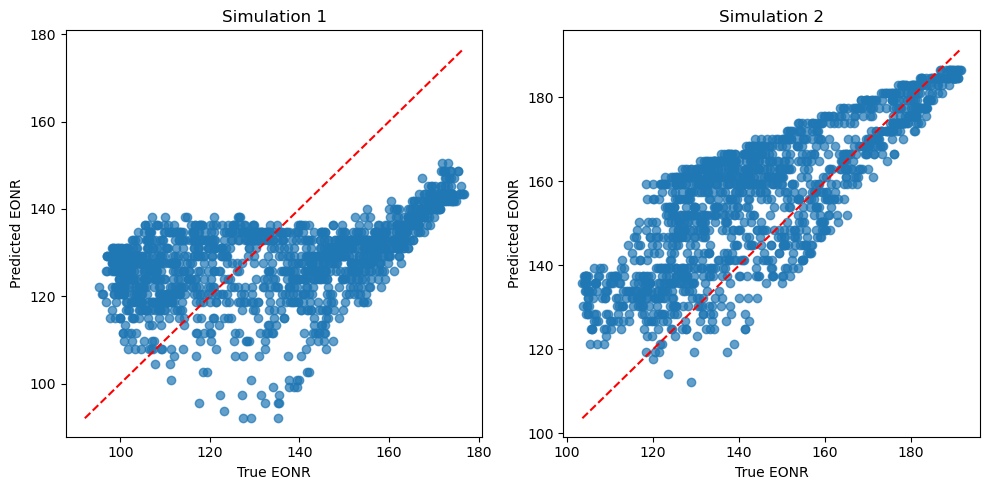

In [ ]:
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt

#  all EONR csv files 
file_list = glob.glob('./Res_1/EONR_*.csv')
num_files = len(file_list)

#  grid layout 
cols = 2
rows = math.ceil(num_files / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)

for idx, file in enumerate(file_list):
  
    df = pd.read_csv(file, index_col=0)
    
   
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    
    #  plot: true vs. predicted EONR
    ax.scatter(df['true'], df['pred'], alpha=0.7)
    ax.set_xlabel('True EONR')
    ax.set_ylabel('Predicted EONR')
    
   
    sim_id = file.split('_')[-1].replace('.csv', '')
    ax.set_title(f"Simulation {sim_id}")
    
   
    min_val = min(df['true'].min(), df['pred'].min())
    max_val = max(df['true'].max(), df['pred'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')


for idx in range(num_files, rows*cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()
